In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def warpImages(img1, img2, H):
	rows1, cols1 = img1.shape[:2]
	rows2, cols2 = img2.shape[:2]

	list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
	temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

	list_of_points_2 = cv.perspectiveTransform(temp_points, H)

	list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

	[x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
	[x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

	translation_dist = [-x_min, -y_min]

	H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

	output_img = cv.warpPerspective( img2, H_translation.dot(H), (x_max-x_min, y_max-y_min) )
	output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

	return output_img

In [3]:
def mergeTwoImages(img1, img2):
    orb = cv.ORB_create(nfeatures=2000)

    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    bf = cv.BFMatcher_create(cv.NORM_HAMMING)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    all_matches = []
    for m, n in matches:
        all_matches.append(m)

    good = []
    for m, n in matches:
        if m.distance < 0.95 * n.distance:
            good.append(m)

    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    M, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 3.0)
    return warpImages(img2, img1, M)

In [4]:
def mergeImages(dir):
    it = os.scandir(dir)
    first = next(it)
    result = cv.imread(first.path)

    for entry in it:
        img = cv.imread(entry.path)
        result = mergeTwoImages(result, img)
    
    return result

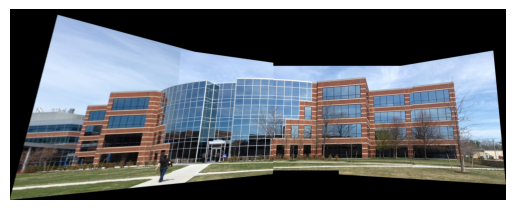

In [5]:
img1 = cv.imread("data/building1/building1.jpg")
img2 = cv.imread("data/building1/building2.jpg")
img3 = cv.imread("data/building1/building3.jpg")
img4 = cv.imread("data/building1/building4.jpg")
img5 = cv.imread("data/building1/building5.jpg")

img45 = mergeTwoImages(img5, img4)
img12 = mergeTwoImages(img1, img2)
img123 = mergeTwoImages(img12, img3)
result = mergeTwoImages(img123, img45)

plt.axis("off")
plt.imshow(result[:, :, ::-1])

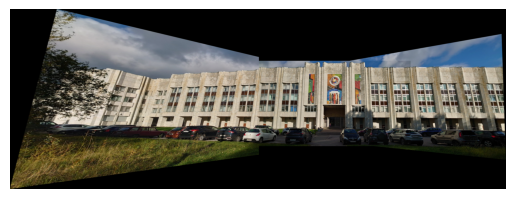

In [6]:
img1 = cv.imread("data/building2/dsc_2707.jpg")
img2 = cv.imread("data/building2/dsc_2708.jpg")
img3 = cv.imread("data/building2/dsc_2709.jpg")
img4 = cv.imread("data/building2/dsc_2710.jpg")
img5 = cv.imread("data/building2/dsc_2711.jpg")

img23 = mergeTwoImages(img2, img3)
img234 = mergeTwoImages(img4, img23)

plt.axis("off")
plt.imshow(img234[:, :, ::-1])

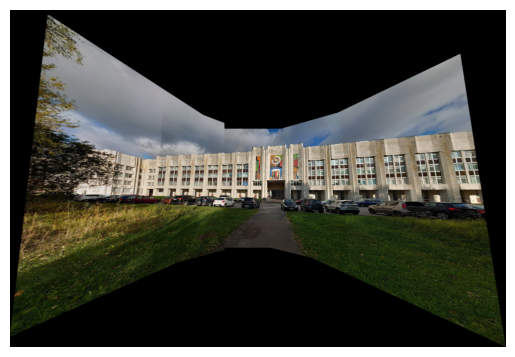

In [7]:
img1 = cv.imread("data/building3/dsc_2721.jpg")
img2 = cv.imread("data/building3/dsc_2722.jpg")
img3 = cv.imread("data/building3/dsc_2723.jpg")
img4 = cv.imread("data/building3/dsc_2724.jpg")
img5 = cv.imread("data/building3/dsc_2725.jpg")
img6 = cv.imread("data/building3/dsc_2726.jpg")
img7 = cv.imread("data/building3/dsc_2727.jpg")

img23 = mergeTwoImages(img2, img3)
img56 = mergeTwoImages(img6 ,img5)
img234 = mergeTwoImages(img23, img4)
img23456 = mergeTwoImages(img56, img234)

plt.axis("off")
plt.imshow(img23456[:, :, ::-1])